In [1]:
import numpy as np
from scipy.signal import medfilt
import matplotlib.pyplot as plt
import soundfile as sf
import random, pdb, os, argparse, shutil, pickle, sys, csv, torch, yaml
from torch.backends import cudnn
from collections import OrderedDict

sys.path.insert(1, '/homes/bdoc3/my_utils')
from my_arrays import fix_feat_length, container_to_tensor, tensor_to_array
from my_os import recursive_file_retrieval
from my_audio.pitch import midi_as_onehot

import utils

sys.path.insert(1, '/homes/bdoc3/autoSvc')
from convert.synthesis import build_model, wavegen


# taken from https://gist.github.com/alimanfoo/c5977e87111abe8127453b21204c1065
def find_runs(x):
    """Find runs of consecutive items in an array."""

    # ensure array
    x = np.asanyarray(x)
    if x.ndim != 1:
        raise ValueError('only 1D array supported')
    n = x.shape[0]

    # handle empty array
    if n == 0:
        return np.array([]), np.array([]), np.array([])

    else:
        # find run starts
        loc_run_start = np.empty(n, dtype=bool)
        loc_run_start[0] = True
        np.not_equal(x[:-1], x[1:], out=loc_run_start[1:])
        run_starts = np.nonzero(loc_run_start)[0]

        # find run values
        run_values = x[loc_run_start]

        # find run lengths
        run_lengths = np.diff(np.append(run_starts, n))

        return run_values, run_starts, run_lengths


# parser = argparse.ArgumentParser()
# parser.add_argument('-wc', '--which_cuda', type=str, default='train')
# parser.add_argument('-rn', '--random_num', type=int, default=None)
# config = parser.parse_args()

# if config.random_num == None:
#     trg_dir = str(random.randint(1000,9999))
# else:
#     trg_dir = str(config.random_num)
trg_dir = str(random.randint(1000,9999))

num_model_conds = 4
num_convert_conds = 4
# this_cuda = config.which_cuda
this_cuda = 0
voiced_percent_tolerance = 0.6

model_names = {
               'damp_mel_Size0.25-avgEmbs_with-bestPerformingSIE_mel80-':'M---Sng',
               'damp_mel_Size0.25-avgEmbs_EmbLoss__-bestPerformingSIE_mel80-Cont2':'M-E-Sng',
               'damp_mel_Size0.25-avgEmbs_withCcLoss-autoVc_pretrainedOnVctk_Mels80-':'M-C-Spk',
               'damp_mel_Size0.25-avgEmbs_CcLoss__-bestPerformingSIE_mel80-to500kIters-Cont2':'M-C-Sng'}
ckpt = 'ckpt_500000.pt'
saved_models_dir = '/homes/bdoc3/my_data/autovc_models/autoSvc'
subset = 'test'
SVC_data_dir = '/import/c4dm-02/bdoc3/spmel/damp_qianParams/' +subset
metadata_root_dir = '/homes/bdoc3/my_data/voice_embs_visuals_metadata'
pitch_dir = '/import/c4dm-02/bdoc3/world_data/damp_80_16ms'
wavenet_model_params = '/homes/bdoc3/my_data/autovc_models/checkpoint_step001000000_ema.pth'
converted_voices_dir = '/homes/bdoc3/my_data/audio_data/output_audio/listeningTest3audio/' +trg_dir
device = f'cuda:{this_cuda}'
gender_conds = [(i,j) for i in range(2) for j in range(2)]
gend_dict = {0:'M', 1:'F'}


if not os.path.exists(converted_voices_dir):
    os.makedirs(converted_voices_dir)

# setup synth model
print('building synth model')
cudnn.benchmark = True
torch.cuda.set_device(device)
synth_model = build_model().to(device)
checkpoint = torch.load(wavenet_model_params, map_location='cpu')
new_state_dict = OrderedDict()
for (k, v) in checkpoint["state_dict"].items():
    new_state_dict[k] = v.cuda(device)
synth_model.load_state_dict(new_state_dict)

Model name:  damp_worldWithApers_Size0.25-avgEmbs__svcPitchCond_-bestPerformingSIE_mel80-
building synth model


<All keys matched successfully>

In [47]:
class NoMatchError(Exception):
    pass

def get_gender_lists():
    print('Getting gender info...')
    performer_gender_list = utils.get_damp_gender(ignore_unknowns=True)
    _, spmel_fps = recursive_file_retrieval(SVC_data_dir)
    spmel_perf_id = [os.path.basename(fp).split('_')[0] for fp in spmel_fps]
    performance_gender_subset = [perf_gen for perf_gen in performer_gender_list if perf_gen[0] in spmel_perf_id]
    females = [perf for perf, gend in performance_gender_subset if gend == ' F']
    males = [perf for perf, gend in performance_gender_subset if gend == ' M']
    gender_separated_lists = [males, females]
    return gender_seperated_lists

def get_feats(path):
    spec_feats = np.load(path)
    fn = os.path.basename(path)
    world_feats = np.load(os.path.join(pitch_dir, subset, fn.split('_')[0], fn))
    pitches = world_feats[:,-2:]
    midi_contour = pitches[:,0]
    unvoiced = pitches[:,1].astype(int) == 1
    midi_contour[unvoiced] = 0
    pitch_feats = midi_contour
    pitch_feats = midi_as_onehot(pitch_feats, midi_range)
    return spec_feats, pitch_feats


def get_song_path(gender):
    
    gender_list = gender_separated_lists[gender]
    rand_int = random.randint(0,len(gender_list)-1)
    name = gender_list[rand_int]
#     gender_list.pop(rand_int)
    song_list = os.listdir(os.path.join(SVC_data_dir, name))
    song_name = random.choice(song_list)
    song_path = os.path.join(SVC_data_dir, name, song_name)

    return song_path, rand_int

def get_relevant_avg_pitches(continuous_pitch_feats, window_size, irrelenvant_ind=0):
    average_pitches = []
    for idx in range(len(continuous_pitch_feats)-window_size):
        avging_window = continuous_pitch_feats[idx:idx+window_size]
        voiced_window = avging_window!=0

        if sum(voiced_window) != irrelenvant_ind:
            window_average = round(np.average(avging_window[voiced_window]))
        else:
            window_average = 0

        average_pitches.append(window_average)

    average_pitches = np.asarray(average_pitches)
    pdb.set_trace()
    average_pitches = np.concatenate((average_pitches, np.zeros((window_size))
    return average_pitches

def matching_pitch_clip(trg_gender, avg_src_pitch, src_path, track_search_tolerance=10, voiced_percent_tolerance=0.7):
    
    matched_singer_found = False
    attempt_num = 0
    while matched_singer_found==False:
        
        trg_path, trg_rand_gend_int = get_song_path(trg_gender)s
        if os.path.dirname(trg_path) == os.path.dirname(src_path):
            continue
    
        print(f'attempt num: {attempt_num}, candidate_song: {os.path.basename(trg_path)}')
        trg_spec_feats, trg_pitch_feats = get_feats(trg_path)
        continuous_pitch_feats = np.argmax(trg_pitch_feats, axis=1)
        average_trg_pitches = get_relevant_avg_pitches(continuous_pitch_feats, window_timesteps)
        start_of_chunk_idx = best_pitch_matching_idx(average_trg_pitches, avg_src_pitch)
        
        if start_of_chunk_idx >= 0:
            trg_pitch_clip, _ = fix_feat_length(trg_pitch_feats, window_timesteps, offset=start_of_chunk_idx)
            voiced = np.argmax(trg_pitch_clip, axis=1) != 0
            if (sum(voiced) / len(voiced)) < voiced_percent_tolerance:
                continue
            matched_singer_found = True
            break
        
        attempt_num += 1
        if attempt_num >= track_search_tolerance:
            raise NoMatchError(f'No matching pitches after searching {attempt_num} target candidates' )
            
    trg_spec_clip, _ = fix_feat_length(trg_spec_feats, window_timesteps, offset=start_of_chunk_idx)
    
    return trg_spec_clip, trg_pitch_clip, trg_rand_gend_int, trg_path


# find continuous chunks that are within tolerance of reference pitch, return the index of the random one
def best_pitch_matching_idx(average_trg_pitches, ref_pitch, tolerance=2, min_avg_pitch_dur=10):

    above_lower = average_trg_pitches > (ref_pitch - tolerance)
    below_upper = average_trg_pitches < (ref_pitch + tolerance)
    within_range_pitches = above_lower & below_upper
#     pdb.set_trace()
    eligible_run_indices = []
    vals, starts, lengths = find_runs(within_range_pitches)
    # for chunks of True in boolean array, if length is long enough, save in list
    for i in range(len(vals)):
        if vals[i]:
            if lengths[i] >= min_avg_pitch_dur:
                eligible_run_indices.append(i)
    if len(eligible_run_indices) == 0:
        return -1
    else:
        chosen_run_idx = random.choice(eligible_run_indices)
        return starts[i]
    
    
def pitch_matched_src_trg(src_gender, trg_gender):

    matching_target_found = False
    while not matching_target_found:
        src_path, src_rand_gend_int = get_song_path(src_gender)
    #     src_path = '/import/c4dm-02/bdoc3/spmel/damp_qianParams/test/434587164/434587164_2141814685.npy'

        src_spec_feats, src_pitch_feats = get_feats(src_path)

        rand_ts = random.randint(0, len(src_spec_feats)-window_timesteps-1)
    #     rand_ts = 2981

        src_clipped_spec, _ = fix_feat_length(src_spec_feats, window_timesteps, offset=rand_ts)
        src_clipped_pitches, _ = fix_feat_length(src_pitch_feats, window_timesteps, offset=rand_ts)
        # ensure we do not include avereaging over zero values which represents unvoiced
        voiced = np.argmax(src_clipped_pitches, axis=1)!=0
        if (sum(voiced) / len(voiced)) < voiced_percent_tolerance:
            continue
        avg_src_pitch = round(np.average(np.argmax(src_clipped_pitches, axis=1)[voiced]))

        print(f'src_song: {os.path.basename(src_path)}, rand_int: {rand_ts}, src_gend: {gend_dict[src_gender]}, avg_src_pitch: {avg_src_pitch}')

        print(avg_src_pitch)
        try:
            spec_pitch_randint = matching_pitch_clip(trg_gender,
                                                     avg_src_pitch,
                                                     src_path,
                                                     voiced_percent_tolerance=voiced_percent_tolerance)

            trg_spec_clip, trg_pitch_clip, trg_rand_gend_int, trg_path = spec_pitch_randint
            gender_separated_lists[src_gender].pop(src_rand_gend_int)
            gender_separated_lists[src_gender].pop(trg_rand_gend_int)
            matching_target_found = True
        except NoMatchError as e:
            continue
    
    src_data = src_clipped_spec, src_clipped_pitches, src_path
    trg_data = trg_spec_clip, trg_pitch_clip, trg_path
            
    return src_data, trg_data

def parse_data(data):
    clipped_spec, clipped_pitches, path = data
    voice_id = os.path.basename(path).split('_')[0]
    sie_emb = subset_metadata[subset_names.index(voice_id)][1]
    arr_list = [clipped_spec, clipped_pitches, sie_emb]
    tns_list = [container_to_tensor(arr, add_batch_dim=True, device=device) for arr in arr_list]
    clipped_spec, clipped_pitches, sie_emb = tns_list
    fn = os.path.basename(path)
    return clipped_spec, clipped_pitches, sie_emb, fn

def get_fn_string(src_fn, trg_fn, rand_ts):
    model_str = model_names[model_name]
    src_str = gend_dict[src_gender] +src_fn.split('_')[0]
    trg_str = gend_dict[trg_gender] +trg_fn.split('_')[0]
    return model_str +f'_{src_str}' +f'_timestep{rand_ts}' +f'_{trg_str}'

Getting gender info...
src_song: 473926181_1927111247.npy, rand_int: 1526, src_gend: M, avg_src_pitch: 22
22
attempt num: 0, candidate_song: 792755197_2063165078.npy
trg_song: 792755197_2063165078.npy, trg_gend: M, avg_trg_pitch: 23.485148514851485


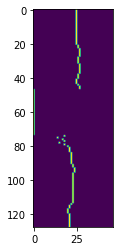

In [48]:
for j, model_name in enumerate(model_names.keys()):

    # model_name = 'damp_mel_Size0.25-avgEmbs_with-bestPerformingSIE_mel80-'

    # load up models
    this_svc_model_dir = os.path.join(saved_models_dir, model_name)
    ckpt_path = os.path.join(this_svc_model_dir, ckpt)
    # if j != 0:
    #     del sys.path[1]
    sys.path.insert(1, this_svc_model_dir)
    from this_train_params import *
    if not 'pkl_fn_extras' in globals():
        pkl_fn_extras = ''

    with open(os.path.join(SVC_feat_dir, 'feat_params.yaml')) as File:
        SVC_feat_params = yaml.load(File, Loader=yaml.FullLoader)
    with open(os.path.join(SIE_feat_dir, 'feat_params.yaml')) as File:
        SIE_feat_params = yaml.load(File, Loader=yaml.FullLoader)

    if SVC_pitch_cond:
        pitch_dim = len(midi_range)+1
    else:
        pitch_dim = 0

    print(f'Loading model: {model_name}')
    G, _, _ = utils.setup_gen(dim_neck, dim_emb, dim_pre, sample_freq, 80, pitch_dim, device, ckpt_path, adam_init)

    sie_model_name = os.path.basename(SIE_model_path)
    SIE_dataset_name = os.path.basename(SIE_feat_dir)
    metadata_path = os.path.join(metadata_root_dir,
                                 sie_model_name,
                                 SIE_dataset_name,
                                 subset,
                                 f'voices_metadata{pkl_fn_extras}.pkl')
    subset_metadata = pickle.load(open(metadata_path, "rb"))
    subset_names = [metad[0] for metad in subset_metadata]

    # if model_name == 'damp_mel_Size0.25-avgEmbs_withCcLoss-autoVc_pretrainedOnVctk_Mels80-':
    #     temp_gender_conds = gender_conds[2:]
    # else:
    #     temp_gender_conds = gender_conds

    temp_gender_conds = gender_conds

    # GET GENDER LIST OF DAMP SINGERS AND USE ONLY TEST SUBSET ENTRIES

    for i, (src_gender, trg_gender) in enumerate(temp_gender_conds):

    #     src_gender, trg_gender = (0, 0)
        print(f'Getting feats for condition: {i+1}')
        src_data, trg_data = pitch_matched_src_trg(src_gender, trg_gender, voiced_percent_tolerance)
        src_clipped_spec, src_clipped_pitches, src_sie_emb, src_fn = parse_data(src_data)
        trg_clipped_spec, trg_clipped_pitches, trg_sie_emb, trg_fn = parse_data(trg_data)

        if SVC_pitch_cond:
            src_pitch_tns = None

        # conversion
        _, converted_feats, _, _, _ = G(src_clipped_spec_tns, src_emb_tns, trg_emb_tns, src_pitch_tns)
        converted_feats = tensor_to_array(converted_feats)
        converted_name = get_fn_string(src_fn, trg_fn, rand_ts)

        # synthesis
        dst_dir = os.path.join(converted_voices_dir, converted_name) +'.wav'
        if os.path.exists(dst_dir):
            continue
        print(f'Synthesizing converted audio at: {dst_dir}')
        waveform = wavegen(synth_model, this_cuda, c=converted_feats)
        sf.write(dst_dir, waveform, samplerate=SVC_feat_params['sr'])